# EECS 4404 Group Project
## Author: Oyinkansola Ajibola, Jianhui Qi, Muhammad Fahad Sohail, Kwonmin Bok

**Original Dataset Source: Shanks0465. (2019). <i>Braille Character Dataset</i> [Data set]. Kaggle. https://www.kaggle.com/datasets/shanks0465/braille-character-dataset**

# Braille Character Dataset Description  
This dataset was created for the purpose of training a CNN for Braille Character Recognition.

**Image Description:**  
Each image is a 28x28 image in Black and White Scale.
Each image name consists of the character alphabet and the number of the image and the type of data augmentation it went through.
(i.e whs - width height shift, rot - Rotation, dim - brightness)

**Dataset composition:**  
26 characters * 3 Augmentations * 20 different images of different augmentation values
(i.e different shift,rotational and brightness values.)

# 1 - Look at the big picture and frame the problem.

## Frame the problem
1. Supervised learning
2. A multi-class classification task
3. Batch learning

## Look at the big picture
Predict the image and classify the braille character to english character.  
It will help individuals with visual impairments to read the braille without physical touching.

# 2 - Load and Preprocess the dataset

### 2.0 - Import libraries

In [ ]:
# Import libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for accessing directory and image
from pathlib import Path
import cv2

# Libraries to display CNN model
# from keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.utils.vis_utils import model_to_dot
# from IPython.display import SVG
import IPython.display

### 2.1 - load and preprocess the dataset

In [ ]:
# Set a dataset path and get all file paths
dataset_dir = Path("./dataset/original_imgs/")
file_list = list(dataset_dir.glob("*.jpg"))

In [ ]:
# # Create 2 arrays to store image inputs and labels
labels = []
images = []

# Read image file and store RGB values into the array
# Read the name of the image file and store its classifier
for file in file_list:
    image = cv2.imread(str(file))
    images.append(image)

    # Extract a file name of the image and transform the class to numeric value
    # Each file name of the image starts with its class
    # e.g.,) 'a1.JPG0dim.jpg' indicates the class of the image is 'a' and its numeric class is 0.
    #        Numeric classes are a = 0, b = 1, ... , and z = 25
    label = ord(os.path.basename(file)[0]) - ord('a')
    labels.append(label)

# Change the array to numpy array
images = np.array(images)
labels = np.array(labels)

### 2.2 - Split dataset into training and test set

In [ ]:
# Split the dataset into 80% training set and 20% test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

### 2.3 - Create color variation augmentated dataset for testing

In [ ]:
from PIL import Image
import glob
import random
random.seed(10)

img_size = len(X_train[0][0])

X_col_test = np.copy(X_test)
for image, label in zip(X_col_test, y_test):
    ranval=random.randrange(240, 255)
    ranrgb=random.randrange(3)

    for x in range(0, img_size):
        for y in range(0, img_size):
            if ranrgb == 0:
                image[x][y][0] = ranval
            elif ranrgb == 1:
                image[x][y][1] = ranval
            else:
                image[x][y][2] = ranval

### 2.3 - Take a quick look at the test dataset and augmentated dataset

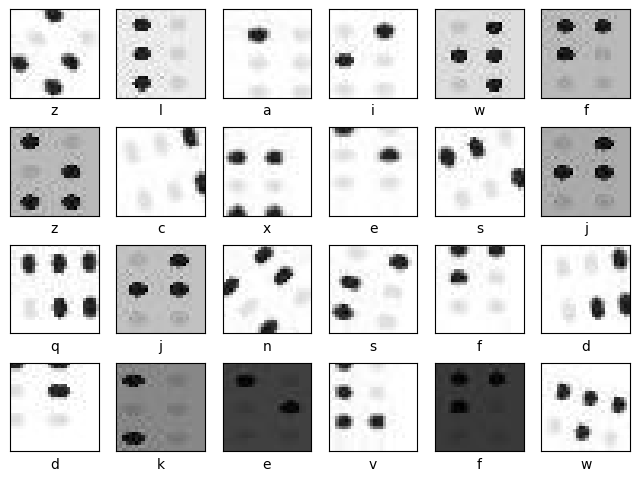

In [6]:
# plot 24 images from the image datasets with the class name below each image
plt.figure(figsize = (8, 12))
for i in range(24):
    plt.subplot(8, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(X_test[i * 3])
    plt.xlabel(chr(y_test[i * 3] + ord('a')))
plt.show()

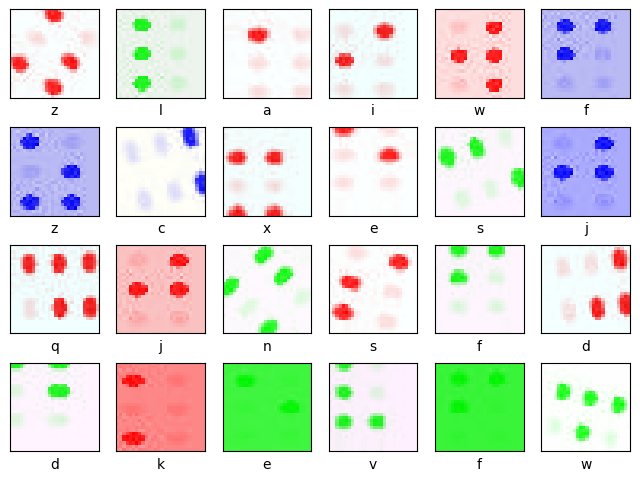

In [7]:
# To verify that the dataset is correctly modified,
# plot 24 images from the image datasets with the class name below each image
plt.figure(figsize = (8, 12))
for i in range(24):
    plt.subplot(8, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(X_col_test[i * 3])
    plt.xlabel(chr(y_test[i * 3] + ord('a')))
plt.show()

### 2.4 - Take a look at CNN process

In [8]:
# Copy braille image of 'a' and 'b' to show the CNN process
# Search the index of the first hit
# index_a = np.where(y_test == 0)[0][0]
# index_b = np.where(y_test == 1)[0][0]

# image_a = np.copy(X_test[index_a])
# image_b = np.copy(X_test[index_b])

# sample_images = np.array([image_a, image_b])
# sample_labels = np.array(['a', 'b'])

# image_c = image_a.reshape(28, 28, 1)

# # Display the image before the processing
# plt.figure(figsize = (4, 4))
# for i in range(len(sample_images)):
#     plt.subplot(2, 2, i + 1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)

#     plt.imshow(sample_images[i])
#     plt.xlabel(sample_labels[i])

# # Create a filter
# kernel = tf.constant([
#     [-1, -2, -1],
#     [0, 0, 0],
#     [1, 2, 1]
# ])

# print(sample_images.shape)
# sample_images = tf.image.convert_image_dtype(sample_images, dtype=tf.float32)
# sample_images = tf.expand_dims(sample_images, axis=0)
# print(sample_images.shape)

# print(kernel.shape)
# kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
# print(kernel.shape)
# kernel = tf.cast(kernel, dtype = tf.float32)
# # print(kernel.shape)
# print(sample_images.shape)

# image_filter = tf.nn.conv2d(
#     input=sample_images,
#     filters=kernel,
#     strides=1,
#     padding='SAME',
# )

# plt.imshow(tf.squeeze(image_filter))


# 3 - Create and train a CNN model

### 3.1 - Create a Convolutional Neural Network model

In [9]:
# Create augmented train set with RGB modification 
from PIL import Image
import glob
import random

#  For reproducability
random.seed(10)

X_train_col = np.copy(X_train)
# img_size = len(X_train_mixed[0][0])

# Augment 10% of train set
# X_train_orig, X_train_col = train_test_split(X_train, test_size=0.1, random_state=42)

for image, label in zip(X_train_col, y_test):
    ranval=random.randrange(240, 255)
    ranrgb=random.randrange(3)

    for x in range(0, img_size):
        for y in range(0, img_size):
            if ranrgb == 0:
                image[x][y][0] = ranval
            elif ranrgb == 1:
                image[x][y][1] = ranval
            else:
                image[x][y][2] = ranval


X_train_mixed = np.concatenate((X_train, X_train_col), axis=0)
y_train_mixed = np.concatenate((y_train, y_train), axis=0)
# np.random.shuffle(X_train_mixed)

print(len(X_train_mixed))

2496


In [10]:
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=5, activation='relu', padding='same',
    input_shape=(28, 28, 3)),
    layers.MaxPool2D(pool_size=2),

    # layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same',),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same',),
    layers.MaxPool2D(pool_size=2),

    # layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same',),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same',),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same',),
    layers.MaxPool2D(pool_size=2),

    layers.Flatten(),
    layers.Dense(units=520, activation='relu'),
    layers.Dense(units=260, activation='relu'),
    layers.Dense(units=26, activation='softmax'),
])

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='SparseCategoricalCrossentropy',
    metrics=['sparse_categorical_accuracy'],
)

### 3.2 - Train the model with training set

In [12]:
# from keras.callbacks import EarlyStopping

# es11 = EarlyStopping(patience=20, monitor="val_sparse_categorical_accuracy", mode="auto")
# es22 = EarlyStopping(patience=20, monitor="val_loss", mode="auto")

history = model.fit(
    x=X_train_mixed,
    y=y_train_mixed,
    epochs=30,
    validation_split=0.1,
    # callbacks=[es11, es22]
)

Epoch 1/30


71/71 [==============================] - 3s 33ms/step - loss: 5.7297 - sparse_categorical_accuracy: 0.1082 - val_loss: 2.7849 - val_sparse_categorical_accuracy: 0.2120
Epoch 2/30
71/71 [==============================] - 2s 30ms/step - loss: 1.8807 - sparse_categorical_accuracy: 0.4898 - val_loss: 1.1769 - val_sparse_categorical_accuracy: 0.6720
Epoch 3/30
71/71 [==============================] - 2s 30ms/step - loss: 0.9248 - sparse_categorical_accuracy: 0.7329 - val_loss: 0.5902 - val_sparse_categorical_accuracy: 0.8160
Epoch 4/30
71/71 [==============================] - 2s 30ms/step - loss: 0.4804 - sparse_categorical_accuracy: 0.8589 - val_loss: 0.3004 - val_sparse_categorical_accuracy: 0.9280
Epoch 5/30
71/71 [==============================] - 2s 30ms/step - loss: 0.2213 - sparse_categorical_accuracy: 0.9310 - val_loss: 0.2984 - val_sparse_categorical_accuracy: 0.9120
Epoch 6/30
71/71 [==============================] - 2s 31ms/step - loss: 0.1166 - sparse_categorical_ac

### 3.3 - Display summary of the model

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         5

In [16]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
# Output network visualization
# keras.utils.plot_model(model, to_file='plot_model.png', show_shapes=True)
# IPython.display.Image('plot_model.png')
# IPython.display.SVG(model_to_dot(model).create(prog='dot', format='svg'))

### 3.4 - Plot training history

In [ ]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.title('Loss fitting history')
plt.legend(labels=['Loss', 'Validation loss'])
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()
plt.title('Accuracy fitting history')
plt.legend(labels=['Accuracy', 'Valuation accuracy'])

print("Final loss: {:.16f}".format(history_frame.iloc[-1].loss))
print("Final accuracy: {:.16f}".format(history_frame.iloc[-1].sparse_categorical_accuracy))

# 4 - Test the model with original test set and color variated augmentated test set

In [ ]:
print("Adam Optimizer")
model.evaluate(X_test, y_test)

In [ ]:
print("Adam Optimizer")
model.evaluate(X_col_test, y_test)

# 5 - Compare with other model

## 5.1 - Other Model 1 - referenced by kaggle code
**https://www.kaggle.com/code/amanrosekaursethi/braille-character-detection-using-cnn**

### 5.1.1 - Modify dataset and create the model

In [ ]:
# This model uses normalized float RGB values
# Change the datatype and values to correct one for the model
X_train_kag = np.copy(X_train) / 255.0
X_test_kag = np.copy(X_test) / 255.0
X_col_test_kag = np.copy(X_col_test) / 255.0

In [ ]:
model_kag = keras.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.25),   
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.25),   
    keras.layers.BatchNormalization(),

    keras.layers.Flatten(),
    
    keras.layers.Dense(units=576, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(units=288, activation="relu"),

    keras.layers.Dense(units=26, activation="softmax") #output layer
])

In [ ]:
model_kag.compile(optimizer="Adam", loss="SparseCategoricalCrossentropy", metrics=["sparse_categorical_accuracy"])

### 5.1.2 - Setup Early Stopping to prevent overfitting

In [ ]:
from keras.callbacks import EarlyStopping

es1 = EarlyStopping(patience=20, monitor="val_sparse_categorical_accuracy", mode="auto")
es2 = EarlyStopping(patience=20, monitor="val_loss", mode="auto")

#The neural network will stop fitting if it gets 20 epochs without converge

history_kag = model_kag.fit(x=X_train_kag,
                    y=y_train,
                    epochs=100,
                    validation_split=0.3,
                    callbacks=[es1, es2])

### 5.1.3 - Plot model summary and history of training

In [ ]:
model_kag.summary()

In [ ]:
time = np.arange(1, len(history_kag.history['loss'])+1)

In [ ]:
sns.lineplot(data=history_kag.history, x=time, y='loss')
sns.lineplot(data=history_kag.history, x=time, y='val_loss')
plt.title('Loss fitting history')
plt.legend(labels=['Loss', 'Validation loss'])
plt.show()

In [ ]:
sns.lineplot(data=history_kag.history, x=time, y='val_sparse_categorical_accuracy')
sns.lineplot(data=history_kag.history, x=time, y='sparse_categorical_accuracy')
plt.title('Accuracy fitting history')
plt.legend(labels=['Accuracy', 'Valuation accuracy'])
plt.show()

In [ ]:
# print(history_kag.history["loss"][-1])
# print(history_kag.history["sparse_categorical_accuracy"][-1])
print("Final loss: {:.16f}".format(history_kag.history["loss"][-1]))
print("Final accuracy: {:.16f}".format(history_kag.history["sparse_categorical_accuracy"][-1]))

### 5.1.4 - Evaluate the model with original test set and color variated augmented test set

In [ ]:
print("Adam Optimizer")
model_kag.evaluate(X_test_kag, y_test)

In [ ]:
print("Adam Optimizer")
model_kag.evaluate(X_col_test_kag, y_test)

## 5.2 - Other Model 2
### VGG16 - predefined large model supported by Tensor Flow

### 5.2.1 - Resize image size of the original dataset for VGG16 and ResNet50

In [ ]:
# Resize the original image set to 32 * 32 pixels for VGG16 model
X_train_copy = np.copy(X_train)
X_test_copy = np.copy(X_test)
X_col_test_copy = np.copy(X_col_test)

X_train_32 = []
X_test_32 = []
X_col_test_32 = []

for image in X_train_copy:
    image_32 = cv2.resize(image, (32,32))
    X_train_32.append(image_32)

for image in X_test_copy:
    image_32 = cv2.resize(image, (32,32))
    X_test_32.append(image_32)

for image in X_col_test_copy:
    image_32 = cv2.resize(image, (32,32))
    X_col_test_32.append(image_32)

X_train_32 = np.array(X_train_32)
X_test_32 = np.array(X_test_32)
X_col_test_32 = np.array(X_col_test_32)

### 5.2.2 - Load, compile, and train the model

In [ ]:
# Load VGG16 model
model_vgg = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(32, 32, 3),
    pooling=None,
    classes=26,
    classifier_activation="softmax",
)


In [ ]:
model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='SparseCategoricalCrossentropy',
    metrics=['sparse_categorical_accuracy']
)

history_vgg = model_vgg.fit(
    x=X_train_32,
    y=y_train,
    epochs=30,
    verbose=0,
)

### 5.2.3 - Plot model summary and history of training

In [ ]:
model_vgg.summary()

In [ ]:
import pandas as pd

history_vgg_frame = pd.DataFrame(history_vgg.history)
history_vgg_frame.loc[:, ['loss']].plot()
history_vgg_frame.loc[:, ['sparse_categorical_accuracy']].plot()

print("Final loss: {:.16f}".format(history_vgg_frame.iloc[-1].loss))
print("Final accuracy: {:.16f}".format(history_vgg_frame.iloc[-1].sparse_categorical_accuracy))

### 5.2.4 - Evaluate the model with the original test set and color variated augmented test set

In [ ]:
print("Adam Optimizer")
model_vgg.evaluate(X_test_32, y_test)

In [ ]:
print("Adam Optimizer")
model_vgg.evaluate(X_col_test_32, y_test)

## 5.3 - Other Model 3
### ResNet50 - predefined large model supported by Tesnfor Flow

### 5.3.1 - Load, compile, and train the model

In [ ]:
# Load ResNet50 model
model_res = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(32,32,3),
    pooling=None,
    classes=26,
)

model_res.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='SparseCategoricalCrossentropy',
    metrics=['sparse_categorical_accuracy']
)

history_res = model_res.fit(
    x=X_train_32,
    y=y_train,
    epochs=30,
    verbose=0,
)

### 5.3.2 - Plot model summary and history of training

In [ ]:
model_res.summary()

In [ ]:
import pandas as pd

history_res_frame = pd.DataFrame(history_res.history)
history_res_frame.loc[:, ['loss']].plot()
history_res_frame.loc[:, ['sparse_categorical_accuracy']].plot()

print("Final loss: {:.16f}".format(history_res_frame.iloc[-1].loss))
print("Final accuracy: {:.16f}".format(history_res_frame.iloc[-1].sparse_categorical_accuracy))

### 5.3.3 - Evaluate the model with the original test set and color variated augmented test set

In [ ]:
print("Adam Optimizer")
model_res.evaluate(X_test_32, y_test)

In [ ]:
print("Adam Optimizer")
model_res.evaluate(X_col_test_32, y_test)